Исследовательская работа посвящена применению гауссовских процессов к задаче классификации.
Ее можно разделить на несколько частей:
1. Применение разных аппроксимаций для ускорения вычисления апостериорных распределений. 
2. Реализация эффективного сэмплинга из гауссовских процессов. 

Ключевые моменты:
1. Предположение о наличии шума в матрице ковариации
2. Обучение сети для подсчета матрицы
3. continue

In [1]:
import torch
import numpy as np
import GPy
# import gpytorch
import torch.nn as nn
import time
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt

# custom .py files
import analysis
import gpy
import laplace
import laplace_models
import data

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
#device = torch.device("cpu")

Running on the GPU


In [3]:
results_file = open("results.csv", "w")
print(", accuracy, time, UE", file=results_file)

In [4]:
def full_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
full_seed(425)

# Read and prepare data

In [5]:
# ctg = pd.read_excel("CTG.xls", sheet_name = 1, skiprows = [0])
# ctg = ctg.drop(["Unnamed: 9", "Unnamed: 31", "Unnamed: 42", "Unnamed: 44", "b", "e", "AC", 
#                 "FM", "UC", "DL", "DS", "DP", "DR", "Nmax", "Nzeros", "A", "B", "C", "D", 
#                 "E", "AD", "DE", "LD", "FS", "SUSP", "CLASS", "Tendency", "DS.1", "DP.1"], axis = 1)
# ctg.dropna(inplace = True)
# ctg[ctg["NSP"] == 3] = 2

# ctg = pd.concat((ctg[ctg["NSP"] == 1].sample(500, random_state = 1), ctg[ctg["NSP"] == 2]))
 
# ctg["NSP"].value_counts()

In [6]:
# X = ctg.values
# ndim = X.shape[1] - 1

# y = X[:, -1] - 1
# X = X[:, :ndim]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
# y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
# print(y_test.mean())

In [7]:
X_train, X_test, y_train, y_test = data.easy_data_preparation('data/bank/bank.csv', sep=';', cat = 1000)
ndim = X_train.shape[1]

# Learn GPy model

In [8]:
k = GPy.kern.Linear(ndim)
lik = GPy.likelihoods.Bernoulli()

start = time.time()
m = GPy.core.GP(
    X      = X_train,
    Y      = y_train, 
    kernel = k, 
    inference_method = GPy.inference.latent_function_inference.laplace.Laplace(),
    likelihood = lik)

m.optimize()

gpy_mean = m.posterior.mean
c1 = m.posterior.covariance
end = time.time()
gpy_time = end - start
print("GPy time: ", gpy_time)

GPy time:  9.802186965942383


In [9]:
gpy_mean
c1.diagonal()

array([0.01781056, 0.1908281 , 0.06890523, 0.04562416, 0.22516797,
       0.07945131, 0.07019251, 0.04291409, 0.04752164, 0.02298492,
       0.05847427, 0.033264  , 0.05582884, 0.03900625, 0.05596179,
       0.02585903, 0.03848808, 0.04413703, 0.02423444, 0.01835721,
       0.05605114, 0.05254905, 0.05431029, 0.05488965, 0.06596875,
       0.0819113 , 0.02912844, 0.03102737, 0.0616905 , 0.04875357,
       0.05365764, 0.04489983, 0.06723666, 0.022749  , 0.01998802,
       0.02138838, 0.03656058, 0.0347817 , 0.02663013, 0.04449202,
       0.03785874, 0.04242374, 0.0308356 , 0.02907045, 0.05717959,
       0.04302483, 0.02578618, 0.03038087, 0.09138144, 0.02009208,
       0.03965035, 0.0312924 , 0.02582854, 0.0704546 , 0.02650278,
       0.05271421, 0.03329618, 0.029743  , 0.04858247, 0.03524369,
       0.04767402, 0.04838092, 0.09125218, 0.12910858, 0.08621003,
       0.02413388, 0.21694403, 0.08467176, 0.06103959, 0.08978686,
       0.0582574 , 0.03539473, 0.05320732, 0.04450386, 0.19989

### Some simple analysis of predictions given by GPy model

In [10]:
gpy_prediction = m.predict(X_test)[0]

print("Range of GPy predictions: ")
print(gpy_prediction.min(), " - ", gpy_prediction.max())
print("mean: ", gpy_prediction.mean())

Range of GPy predictions: 
0.0019519395465715736  -  0.6091359792925488
mean:  0.10793033373349317


linear.,value,constraints,priors
variances,1.692502330624498,+ve,


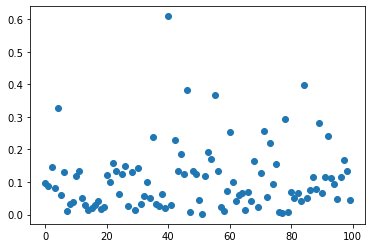

In [11]:
plt.plot(gpy_prediction, 'o')
m.kern

In [12]:
gpy_labels = torch.tensor(gpy_prediction).ge(0.5).float()

gpy_accuracy = accuracy_score(y_test, gpy_labels.cpu())
print("GPy accuracy: ", gpy_accuracy)

GPy accuracy:  0.88


In [13]:
k_s = list(torch.arange(1, 0.5-0.0001, -0.0001))
gpy_prediction = torch.tensor(gpy_prediction)
gpy_auc = analysis.get_uncertainty_curve(
    analysis.predictive_entropy, 
    X_test, 
    torch.tensor(y_test), 
    gpy_prediction, 
    k_s)

In [14]:
print("GPy", 
      round(gpy_accuracy, 2), 
      round(gpy_time, 2), 
      round(np.trapz(gpy_auc, k_s), 2), 
      sep=", ", file=results_file)

In [15]:
def tensor(a, b, c, d, device):
    return torch.tensor(a, dtype = torch.float).to(device), \
            torch.tensor(b, dtype = torch.float).to(device), \
            torch.tensor(c, dtype = torch.float).to(device), \
            torch.tensor(d, dtype = torch.float).to(device)

def error(x, y):
    return torch.norm(x - y) / torch.norm(x), torch.norm(x - y)

X_train, X_test, y_train, y_test = tensor(X_train, X_test, y_train, y_test, device)

# Train neural net - proper feature extractor
You can choose to load pretrained feature exctractor here if you have one

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.56it/s]


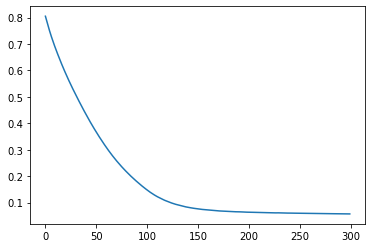

In [16]:
feature_extractor = laplace_models.LargeFeatureExtractor(ndim, predictions=True).to(device)

criterion = nn.CrossEntropyLoss()

params = [{'params': feature_extractor.parameters()}]
optimizer = torch.optim.Adam(params, lr=1e-3)
n_epochs = 300
loss_history = []

for _ in tqdm(range(n_epochs)):
    optimizer.zero_grad() 

    probas = feature_extractor(X_train) 
    
    loss = criterion(probas, y_train.reshape((-1)).long())
    loss_history.append(loss)

    loss.backward()
    # iterator.set_postfix(loss=loss.item()) ?
    optimizer.step()
    
plt.plot(loss_history)

Vanilla neural net accuracy:  0.89


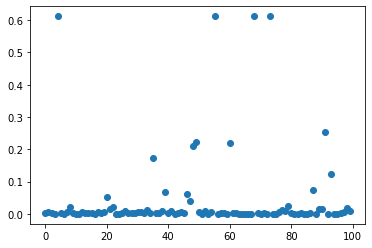

In [17]:
prediction = feature_extractor.predict(X_test)[:, 1]
plt.plot(prediction.detach().cpu().numpy(), 'o')
prediction = prediction.ge(0.5).float()

feature_extractor.predictions = False
torch.save(feature_extractor, "./feature_extractor.pt")

cur_accuracy = accuracy_score(y_test.detach().cpu().numpy(), prediction.detach().cpu().numpy())
print("Vanilla neural net accuracy: ", cur_accuracy)

# Main experiment loop

In [18]:
def train_gp(model, criterion, parameters):
    n_epochs = 50
    lr = 1e-4

    optimizer = torch.optim.Adam(parameters, lr=lr)
    loss_history = []

    start = time.time()
    for i in tqdm(range(n_epochs)):
        optimizer.zero_grad()
        
        f, covar, W, G = model(X_train, y_train, sigma**2)
        loss = criterion(G, sigma**2, W, f, y_train)
        loss_history.append(loss)

        loss.backward()
        # iterator.set_postfix(loss=loss.item()) ?
        optimizer.step()
    end = time.time()
        
    return f, loss_history, end - start

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:58<00:00,  2.37s/it]


Range of network predictions: 
0.2527545  -  0.90187144
mean:  0.5073469
accuracy:  0.59


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.78s/it]


Range of network predictions: 
2.947595e-38  -  1.0
mean:  0.039913148
accuracy:  0.89


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.19it/s]


Range of network predictions: 
0.0  -  1.0
mean:  0.04
accuracy:  0.89


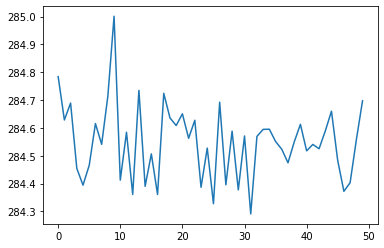

<Figure size 432x288 with 0 Axes>

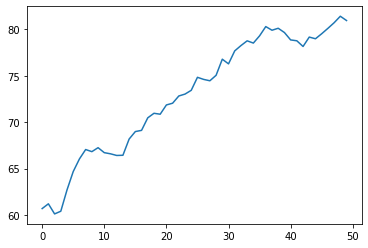

<Figure size 432x288 with 0 Axes>

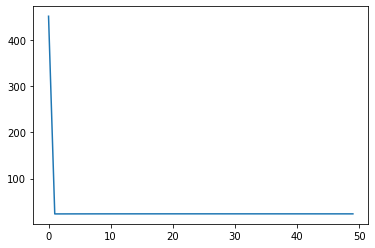

<Figure size 432x288 with 0 Axes>

In [19]:
import copy
feature_extractors = [laplace_models.Identity(), feature_extractor, copy.deepcopy(feature_extractor)]
straights = [True, True, False]
criterions = [laplace.straight_marginal_log_likelihood, \
              laplace.straight_marginal_log_likelihood, \
              laplace.marginal_log_likelihood]
names = ["vanilla GP", "slow deep GP", "fast deep GP"]

results = {}

for feature_extractor, straight, criterion, name in zip(feature_extractors, straights, criterions,names):
    model = laplace_models.DeepGPClassificationModel(feature_extractor, y_train, straight=straight).to(device)
    
    sigma = nn.Parameter(torch.tensor([1e-2], requires_grad=True, device=device))
    parameters = [{'params': model.parameters()}, {'params': sigma}]
    
    f, loss_history, model_time = train_gp(model, criterion, parameters)
    
    plt.figure()
    plt.plot(loss_history[:])
    
    accuracy, probabilities = analysis.get_accuracy_info(model, X_test, y_test, sigma, y_train, lik)
    
    auc = analysis.get_uncertainty_curve(
        analysis.predictive_entropy, 
        X_test, 
        y_test, 
        probabilities, 
        k_s)
    
    results[name] = [accuracy, model_time, auc]
    
    print(name, 
      round(accuracy, 2), 
      round(model_time, 2), 
      round(abs(np.trapz(auc, k_s)), 2), 
      sep=", ", file=results_file)

In [20]:
results_file.close()

Text(0.5, 1.0, 'Approaches comparison')

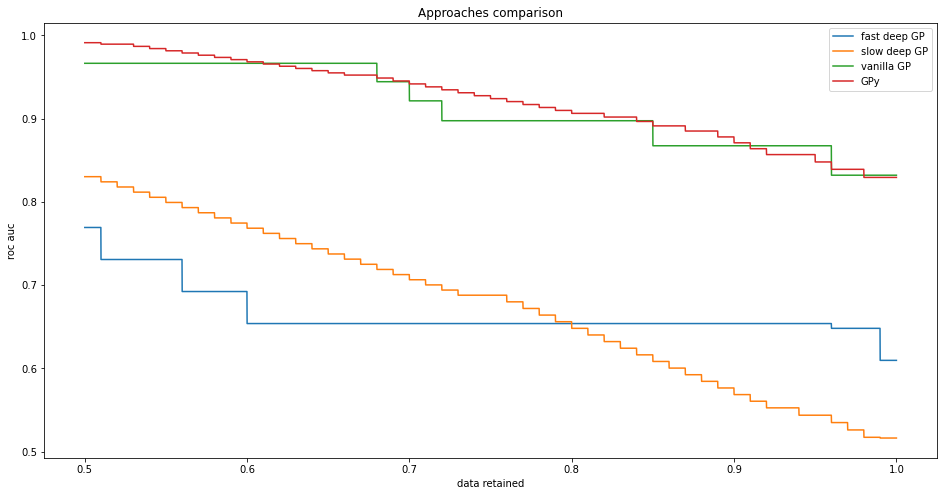

In [21]:
plt.figure(figsize=(16,8))
plt.plot(k_s, results["fast deep GP"][2], label="fast deep GP")
plt.plot(k_s, results["slow deep GP"][2], label="slow deep GP")
plt.plot(k_s, results["vanilla GP"][2], label="vanilla GP")
plt.plot(k_s, gpy_auc, label="GPy")
plt.xlabel("data retained")
plt.ylabel("roc auc")
plt.legend()
plt.title("Approaches comparison")

## Staff

In [22]:
f, covar, W, G = model(X_train, y_train, sigma**2)

In [23]:
f.squeeze().cpu().detach().numpy()

array([ 1.2916186e-03,  7.8284758e-04,  6.4831472e-04,  8.4727944e-04,
        1.4634450e-03,  7.5275084e-04,  7.4307207e-04,  9.7936240e-04,
        1.3243285e-03,  1.3563273e-03,  1.3737433e-03, -6.9333729e-04,
        1.1889628e-03,  1.1294660e-03,  1.0796179e-03,  1.0133355e-03,
        7.9063349e-04,  8.0099277e-04,  6.8587554e-04,  1.2918930e-03,
       -9.0525200e-04,  1.1901483e-03,  1.6371259e-03,  1.0830291e-03,
        9.2940050e-04,  1.6035831e-03,  1.5778591e-04,  5.1594514e-04,
        1.2582939e-03,  1.0010077e-03,  1.3943689e-03, -1.0526039e-03,
        1.0925451e-03,  1.0129060e-03,  8.4344827e-04,  1.4366264e-03,
        5.2597269e-04, -8.8891410e-04,  7.5375574e-04,  8.9678227e-04,
        1.0599615e-03,  1.0771605e-03,  8.5479423e-04,  1.1201249e-03,
        9.8515139e-04,  1.2353710e-03,  1.0401856e-03,  9.3858287e-04,
        7.7254692e-04,  9.8121818e-04, -1.1441672e-03,  9.9518907e-04,
        1.5538731e-03,  1.1701736e-03, -9.4889727e-04,  1.1087474e-03,
      

In [24]:
X_train.size()

torch.Size([900, 16])

In [25]:
f

Parameter containing:
tensor([[ 1.2916e-03],
        [ 7.8285e-04],
        [ 6.4831e-04],
        [ 8.4728e-04],
        [ 1.4634e-03],
        [ 7.5275e-04],
        [ 7.4307e-04],
        [ 9.7936e-04],
        [ 1.3243e-03],
        [ 1.3563e-03],
        [ 1.3737e-03],
        [-6.9334e-04],
        [ 1.1890e-03],
        [ 1.1295e-03],
        [ 1.0796e-03],
        [ 1.0133e-03],
        [ 7.9063e-04],
        [ 8.0099e-04],
        [ 6.8588e-04],
        [ 1.2919e-03],
        [-9.0525e-04],
        [ 1.1901e-03],
        [ 1.6371e-03],
        [ 1.0830e-03],
        [ 9.2940e-04],
        [ 1.6036e-03],
        [ 1.5779e-04],
        [ 5.1595e-04],
        [ 1.2583e-03],
        [ 1.0010e-03],
        [ 1.3944e-03],
        [-1.0526e-03],
        [ 1.0925e-03],
        [ 1.0129e-03],
        [ 8.4345e-04],
        [ 1.4366e-03],
        [ 5.2597e-04],
        [-8.8891e-04],
        [ 7.5376e-04],
        [ 8.9678e-04],
        [ 1.0600e-03],
        [ 1.0772e-03],
        [ 8.

In [26]:
covar.size()

torch.Size([900, 900])

In [27]:
def get_posterior_mean():
    return mean.cpu().detach().numpy()
#     return f.squeeze().cpu().detach().numpy()
def get_posterior_std():
    return covar.cpu().detach().numpy()
#     return c1.diagonal()
#     return covar.diagonal().cpu().detach().numpy()
def h(p):
    return -p * np.log(p) - (1 - p) * np.log(1 - p)
from scipy.stats import norm

def objective():
    return norm.cdf()
def BALD(X):
    mean = get_posterior_mean()
    std = get_posterior_std()
    C = (np.pi * np.log(2) / 2)** 0.5
    objective = h(norm.cdf(mean / (std ** 2 + 1) ** 0.5)) - C * np.exp( - mean ** 2/ (2 * (std ** 2 + C ** 2))) /  (std ** 2 + C ** 2) ** 0.5
    print(objective)
    ind = np.argmax(objective)
    return X[ind], ind

In [28]:
mean, covar, net_prediction = model.predict(X_test, y_train, lik, sigma**2)

In [29]:
x, ind = BALD(X_test)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


 D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:divide by zero encountered in log
 D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in multiply


In [30]:
x

tensor([0.4559, 0.1818, 0.5000, 0.3333, 0.0000, 0.0534, 0.0000, 0.0000, 0.5000,
        0.5333, 0.8182, 0.0775, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')

In [31]:
from analysis import predictive_entropy
predictive_entropy(torch.tensor(net_prediction[0]))

tensor(nan)

In [32]:
x

tensor([0.4559, 0.1818, 0.5000, 0.3333, 0.0000, 0.0534, 0.0000, 0.0000, 0.5000,
        0.5333, 0.8182, 0.0775, 0.0000, 0.0000, 0.0000, 1.0000],
       device='cuda:0')

In [33]:
c1.shape

(900, 900)

In [34]:
gpy_mean.shape

(900, 1)